# Tree-Based Models Exploratory

#### Load

In [2]:
from IPython import get_ipython
if get_ipython() is not None:
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import model_funcs as mf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(9,4)})
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, cross_val_predict,
                                     cross_val_score)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract the results from the grid search

from centraljersey import merge, preprocess

from centraljersey.models import PredictionModels
model = PredictionModels()
df = model.df_tracts

culture_variables = [
    "dunkin_id",
    "wawa_id",
    "giants_or_jets",
    "pork_roll",
    "calm-no-l",
    "almond-no-l",
    "forward-no-r",
    "drawer",
    "gone-don",
]

census_variables = [
    "white_pop",
    "black_pop",
    "asian_pop",
    "occu_Agricul/fish/mining/forest",
    "occu_Construction",
    "occu_Manufacturing",
    "occu_Wholesale trade",
    "occu_Retail trade",
    "occu_transport/warehouse/utils",
    "occu_Information",
    "occu_finance/insurance/realestate",
    "occu_administrative",
    "occu_educational/healthcare/social",
    "occu_arts/entertainment/foodservices",
    "occu_public administration",
    "occu_management, business",
    "occu_Service occupations:",
    "occu_Sales and office occupations:",
    "occu_Natural resources, construction",
    "occu_production/transport/materials",
    "income_150k+",
    "pob_foreign_born",
    "edu_college",
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/chansoo/projects/centraljersey/centraljersey/models.py:17: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.df_county = self.merger.df_counties


# Models

### Census Variables Only

In [99]:
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_features": [
        # "sqrt", "log2", 
        None
    ],
    "max_depth": [3, 6, 9, 12, 15],
    "max_leaf_nodes": [6, 9, 12, 15, 20],
}
grid_search = GridSearchCV(
    model.models["Random Forest"], param_grid=param_grid, verbose=1, n_jobs=10
)
clf = grid_search.fit(model.X[census_variables], model.y)
y_test = clf.predict_proba(model.X_test[census_variables])
model.df_tracts["rf_loc"] = y_test[:, 1]

Fitting 5 folds for each of 125 candidates, totalling 625 fits


Get the parameter names for the grid search

In [100]:
results = clf.cv_results_
df_results = pd.DataFrame(results)
df_results["config"] = df_results.apply(lambda row: "-".join([str(x) for x in row["params"].values()]), axis=1)
df_results = df_results.sort_values('mean_test_score', ascending=False).head(50)


Plot Results

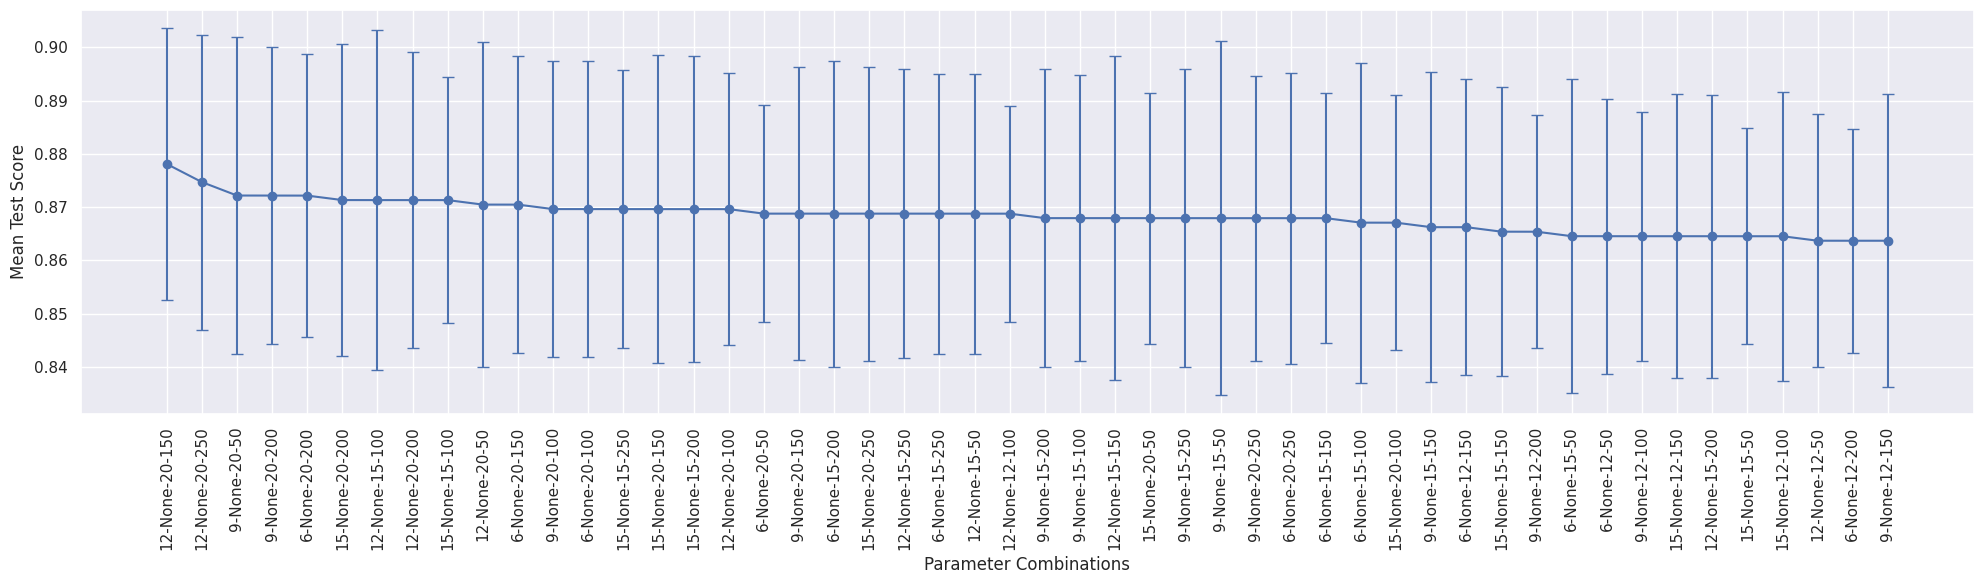

In [101]:
# Create a figure
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the mean scores
ax.plot(range(len(df_results)), df_results["mean_test_score"], 'o-')
ax.set_xticks(range(len(df_results)))
ax.set_xticklabels(df_results["config"], rotation=90)
ax.set_xlabel('Parameter Combinations')
ax.set_ylabel('Mean Test Score')

# Add error bars representing the standard deviation scores
ax.errorbar(range(len(df_results)), df_results["mean_test_score"], yerr=df_results["std_test_score"], fmt='none', capsize=4)

# Show the plot
plt.tight_layout()
plt.show()

#### Feature Importance

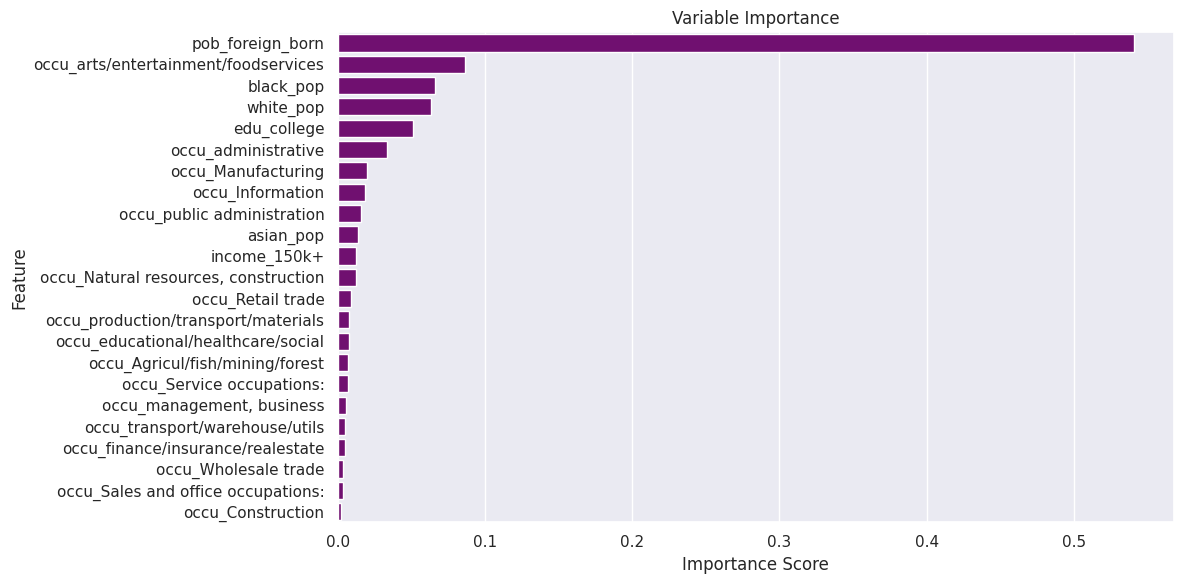

In [112]:
# Get the best estimator from the GridSearchCV
best_estimator = grid_search.best_estimator_
importance_scores = best_estimator.feature_importances_
df_importance = pd.DataFrame({"Feature": census_variables, "Importance": importance_scores})
df_importance = df_importance.sort_values("Importance", ascending=False)

# Plot the variable importance using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=df_importance, color="purple")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Variable Importance")
plt.tight_layout()
plt.show()
